In [1]:


!pip install -q kagglehub pandas scikit-learn nltk wordcloud matplotlib

import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix


import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
import kagglehub


path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")
print("Path to dataset files:", path)
print("Files in path:", os.listdir(path))


fake = pd.read_csv(os.path.join(path, "Fake.csv"))
true = pd.read_csv(os.path.join(path, "True.csv"))


fake["label"] = 0
true["label"] = 1
df = pd.concat([fake, true], ignore_index=True)


print(df.shape)
df.head()

Path to dataset files: /kaggle/input/fake-and-real-news-dataset
Files in path: ['True.csv', 'Fake.csv']
(44898, 5)


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [3]:

for col in ["title", "text"]:
    if col not in df.columns:
        raise ValueError(f"Expected column '{col}' not found in dataset.")

df["text_all"] = (df["title"].fillna("") + " " + df["text"].fillna("")).str.strip()


df = df[df["text_all"].str.len() > 0].copy()


df = df.drop_duplicates(subset=["text_all", "label"]).reset_index(drop=True)


print(df["label"].value_counts())
df[["text_all", "label"]].head()

label
1    21196
0    17907
Name: count, dtype: int64


,text_all,label
0,Donald Trump Sends Out Embarrassing New Year’s...,0
1,Drunk Bragging Trump Staffer Started Russian C...,0
2,Sheriff David Clarke Becomes An Internet Joke ...,0
3,Trump Is So Obsessed He Even Has Obama’s Name ...,0
4,Pope Francis Just Called Out Donald Trump Duri...,0


In [4]:

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(s, do_lemma=True):
    s = s.lower()

    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"<.*?>", " ", s)

    s = re.sub(r"[^a-z\s]", " ", s)

    s = re.sub(r"\s+", " ", s).strip()

    tokens = []
    for w in s.split():
        if w in stop_words:
            continue
        if do_lemma:
            w = lemmatizer.lemmatize(w)
        tokens.append(w)
    return " ".join(tokens)


df["clean_text"] = df["text_all"].apply(lambda x: clean_text(x, do_lemma=True))

df[["clean_text","label"]].head(3)

,clean_text,label
0,donald trump sends embarrassing new year eve m...,0
1,drunk bragging trump staffer started russian c...,0
2,sheriff david clarke becomes internet joke thr...,0


In [5]:


X = df["clean_text"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

len(X_train), len(X_test), y.mean()

(31282, 7821, np.float64(0.5420555967572821))

In [6]:

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    min_df=2
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)

X_train_vec.shape, X_test_vec.shape

((31282, 50000), (7821, 50000))

In [8]:
clf = LogisticRegression(max_iter=300, n_jobs=None)
clf.fit(X_train_vec, y_train)

y_pred = clf.predict(X_test_vec)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}\n")
print(classification_report(y_test, y_pred, target_names=["fake","real"]))

Accuracy:  0.9889
Precision: 0.9866
Recall:    0.9929
F1-score:  0.9898

              precision    recall  f1-score   support

        fake       0.99      0.98      0.99      3582
        real       0.99      0.99      0.99      4239

    accuracy                           0.99      7821
   macro avg       0.99      0.99      0.99      7821
weighted avg       0.99      0.99      0.99      7821



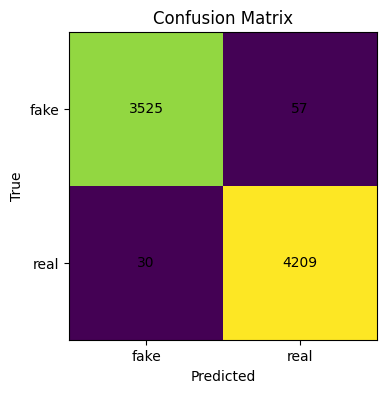

In [9]:

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['fake','real']); ax.set_yticklabels(['fake','real'])
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center")
ax.set_title("Confusion Matrix")
plt.show()

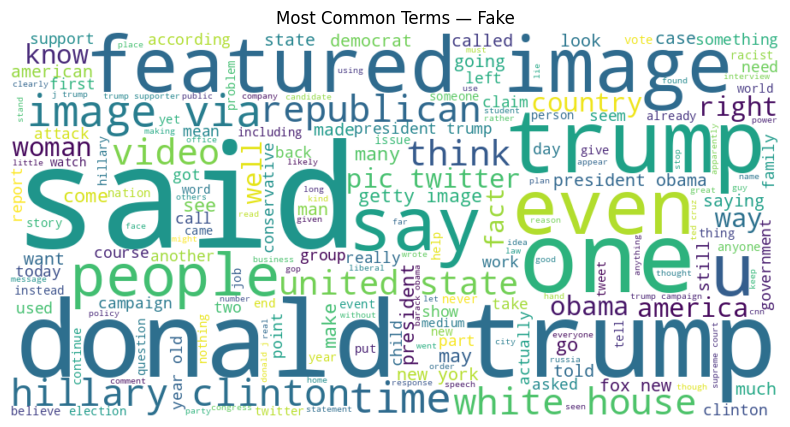

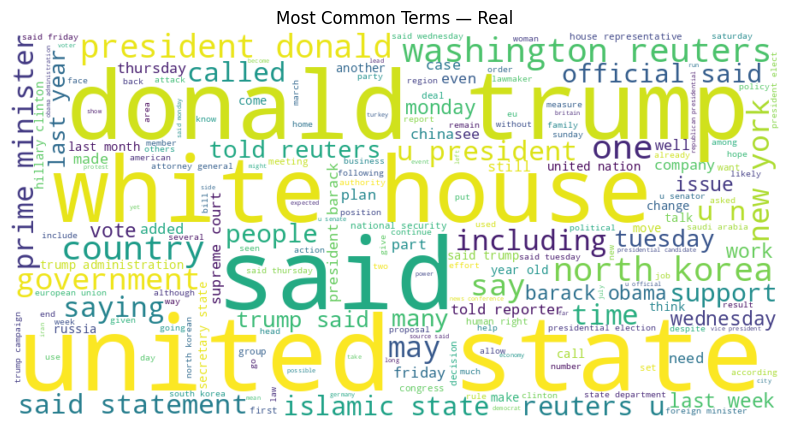

In [10]:

Lfake_text = " ".join(df.loc[df.label==0, "clean_text"].tolist())
real_text = " ".join(df.loc[df.label==1, "clean_text"].tolist())

plt.figure(figsize=(10,5))
wc_fake = WordCloud(width=900, height=450, background_color="white").generate(fake_text)
plt.imshow(wc_fake, interpolation="bilinear"); plt.axis("off")
plt.title("Most Common Terms — Fake"); plt.show()

plt.figure(figsize=(10,5))
wc_real = WordCloud(width=900, height=450, background_color="white").generate(real_text)
plt.imshow(wc_real, interpolation="bilinear"); plt.axis("off")
plt.title("Most Common Terms — Real"); plt.show()

In [11]:

from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train_vec, y_train)
svm_pred = svm.predict(X_test_vec)

acc2 = accuracy_score(y_test, svm_pred)
prec2, rec2, f12, _ = precision_recall_fscore_support(y_test, svm_pred, average="binary")

print("Linear SVM Results")
print(f"Accuracy:  {acc2:.4f}")
print(f"Precision: {prec2:.4f}")
print(f"Recall:    {rec2:.4f}")
print(f"F1-score:  {f12:.4f}")

Linear SVM Results
Accuracy:  0.9946
Precision: 0.9939
Recall:    0.9962
F1-score:  0.9951
